In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima, ndiffs, nsdiffs

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../attributes_dataset/max_temp.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.head()

,max_temp
date,
2016-01-01,27.6
2016-01-02,28.0
2016-01-03,27.9
2016-01-04,27.4
2016-01-05,27.0


# Splitting Data

In [4]:
train_ratio = int(len(df) * 0.9)

In [5]:
dtrain = df.iloc[:train_ratio]
dtest = df.iloc[train_ratio:]

In [6]:
print(dtrain.shape)
print(dtest.shape)

(2053, 1)
(229, 1)


# Visualisasi ACF dan PACF

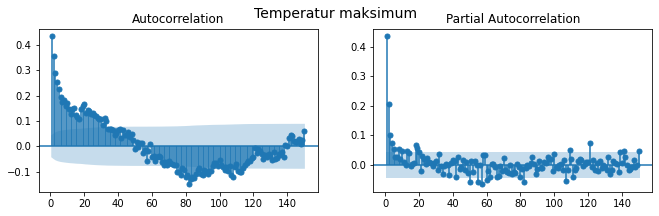

In [7]:
lags = 150
fig, ax = plt.subplots(1,2,figsize=(11,3))
plt.suptitle('Temperatur maksimum', fontsize=14)
sgt.plot_acf(dtrain, lags=lags, zero=False, ax=ax[0])
sgt.plot_pacf(dtrain, lags=lags, zero=False, ax=ax[1])
plt.show()

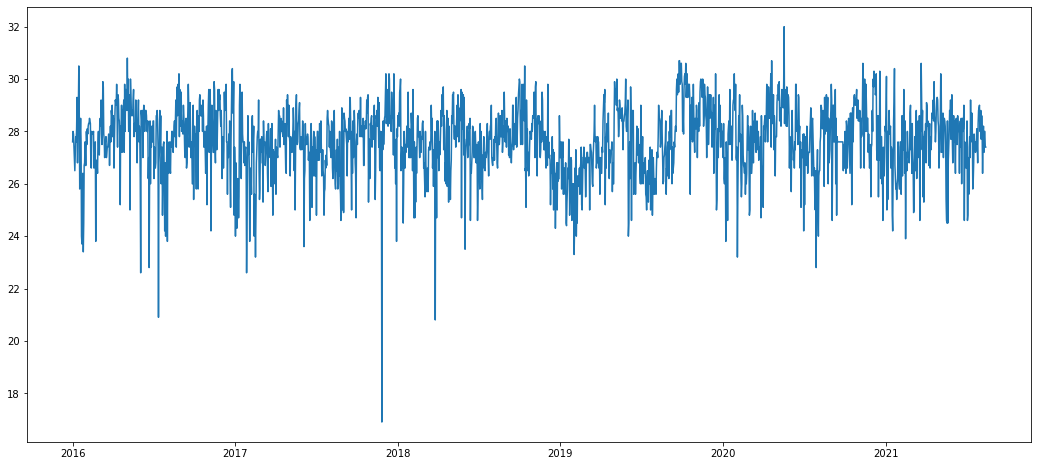

In [8]:
plt.figure(figsize=(18,8))
plt.plot(dtrain)

# Stasionary Test (dickey fuller)

In [9]:
adf = sts.adfuller(dtrain)
print(f'ADF p values\t\t: {adf[1]}')
print(f'ADF statistic values\t: {adf[0]}')
print(f'ADF critical values\t: {adf[4]}')

ADF p values		: 1.2134131425815513e-07
ADF statistic values	: -6.060885870247861
ADF critical values	: {'1%': -3.4335706473104777, '5%': -2.862962721261273, '10%': -2.567527393852395}


In [10]:
# p-value < 0.05 tidak stasioner
sts.kpss(dtrain, regression='ct')

(0.09375852343257232,
 0.1,
 26,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

### Data stasioner karena p values < 0.05 dan statistic values < 5% critical values 

# Levene Test

In [11]:
len_dtrain = len(dtrain)
levgrp_1 = dtrain.max_temp.iloc[int(0.2*len_dtrain):int(0.6*len_dtrain)]
levgrp_2 = dtrain.max_temp.iloc[:int(0.4*len_dtrain)]
levgrp_3 = dtrain.max_temp.iloc[int(0.8*len_dtrain):]
levgrp_4 = dtrain.max_temp.iloc[int(0.2*len_dtrain):int(0.9*len_dtrain)]

In [12]:
tmp1 = levgrp_1.copy()
tmp2 = levgrp_2.copy()
tmp3 = levgrp_3.copy()
tmp4 = levgrp_4.copy()

tmp1_df = pd.DataFrame(data={'date': tmp1.index, 'val': 1})
tmp1_df.set_index('date', inplace=True)

tmp2_df = pd.DataFrame(data={'date': tmp2.index, 'val': 2})
tmp2_df.set_index('date', inplace=True)

tmp3_df = pd.DataFrame(data={'date': tmp3.index, 'val': 3})
tmp3_df.set_index('date', inplace=True)

tmp4_df = pd.DataFrame(data={'date': tmp4.index, 'val': 4})
tmp4_df.set_index('date', inplace=True)

tmp5_df = pd.DataFrame(data={'date': dtrain.index, 'val': 0})
tmp5_df.set_index('date', inplace=True)

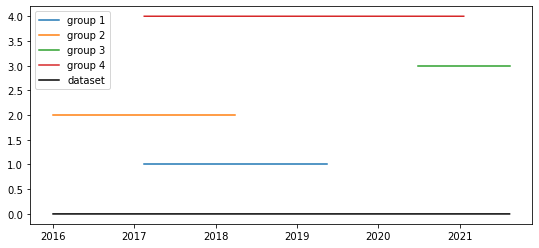

In [13]:
plt.figure(figsize=(9,4))
plt.plot(tmp1_df, label='group 1')
plt.plot(tmp2_df, label='group 2')
plt.plot(tmp3_df, label='group 3')
plt.plot(tmp4_df, label='group 4')
plt.plot(tmp5_df, label='dataset', color='black')
plt.legend()

In [14]:
#levene p-value > 0.05 == varian stasioner

levene_val = stats.levene(levgrp_1, levgrp_2, levgrp_3, levgrp_4, center='mean')
print(levene_val)
if levene_val[1] > 0.05:
    print('Varian Stasioner')
else:
    print('Varian Tidak Stasioner')    


LeveneResult(statistic=1.1871599533536938, pvalue=0.3130414261511174)
Varian Stasioner


# Box Cox transformation

In [15]:
trans = boxcox(dtrain.max_temp)
dtrain_trans = trans[0]
trans_lambdas = trans[1]

In [16]:
df_dtrain_trans = dtrain.copy()
df_dtrain_trans.max_temp = dtrain_trans

# Auto Arima Model

In [17]:
train_exg = pd.read_csv('../R_resource/max_temp_train_exog182.csv')
train_exg = train_exg.drop(columns='Unnamed: 0')

In [18]:
test_exg = pd.read_csv('../R_resource/max_temp_test_exog182.csv')
test_exg = test_exg.drop(columns='Unnamed: 0')

In [19]:
d_value = ndiffs(dtrain)
d_value

0

# Saving Model

In [20]:
## open the model

with open('ARIMA_models/max_temp.pkl', 'rb') as pkl:
    model = pickle.load(pkl)

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2053
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -3003.284
Date:                Sun, 07 Aug 2022   AIC                           6748.568
Time:                        14:04:54   BIC                           8836.207
Sample:                             0   HQIC                          7514.091
                               - 2053                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6744      0.415      1.625      0.104      -0.139       1.488
S1-365        -0.2492      0.190     -1.314      0.189      -0.621       0.122
C1-365         0.0023      0.186      0.013      0.990      -0.361       0.366
S2-365        -0.6026      0.149     -4.032      0.000      -0.896      -0.310
C2-365        -0.3989      0.139     -2.873      0.004      -0.671      -0.127
S3-365         0.0025      0.113      0.022      0.983      -0.219       0.224
C3-365         0.2053      0.122      1.685      0.092      -0.033       0.444
S4-365         0.0064      0.102      0.062      0.950      -0.194       0.207
C4-365        -0.1194      0.104     -1.144      0.253      -0.324       0.085
S5-365        -0.0182      0.095     -0.191      0.849      -0.205       0.169
C5-365         0.0048      0.093      0.052      0.959      -0.178       0.187
S6-365        -0.0163      0.091     -0.180      0.857      -0.194       0.161
C6-365        -0.0142      0.087     -0.163      0.870      -0.185       0.156
S7-365         0.0369      0.083      0.447      0.655      -0.125       0.199
C7-365        -0.0662      0.088     -0.756      0.450      -0.238       0.106
S8-365         0.0409      0.084      0.488      0.626      -0.123       0.205
C8-365         0.0506      0.081      0.622      0.534      -0.109       0.210
S9-365        -0.0576      0.079     -0.734      0.463      -0.212       0.096
C9-365        -0.0508      0.083     -0.612      0.540      -0.213       0.112
S10-365       -0.0601      0.079     -0.763      0.445      -0.214       0.094
C10-365       -0.0474      0.080     -0.592      0.554      -0.204       0.109
S11-365        0.0587      0.081      0.723      0.470      -0.100       0.218
C11-365        0.0060      0.075      0.079      0.937      -0.142       0.153
S12-365        0.0842      0.078      1.082      0.279      -0.068       0.237
C12-365       -0.1211      0.077     -1.576      0.115      -0.272       0.029
S13-365       -0.0039      0.074     -0.053      0.958      -0.149       0.141
C13-365       -0.0178      0.079     -0.225      0.822      -0.173       0.138
S14-365       -0.0004      0.077     -0.005      0.996      -0.151       0.150
C14-365        0.0170      0.075      0.228      0.820      -0.129       0.163
S15-365        0.0699      0.075      0.934      0.350      -0.077       0.217
C15-365        0.0749      0.075      0.993      0.321      -0.073       0.223
S16-365        0.0139      0.073      0.189      0.850      -0.130       0.158
C16-365       -0.0275      0.076     -0.362      0.718      -0.176       0.121
S17-365       -0.0864      0.075     -1.145      0.252      -0.234       0.061
C17-365        0.0483      0.073      0.663      0.507      -0.094       0.191
S18-365       -0.0101      0.073     -0.139      0.890      -0.153       0.133
C18-365        0.1262      0.074      1.705      0.088      -0.019       0.271
S19-365       -0.1071      0.072     -1.479      0.139      -0.249       0.035
C1

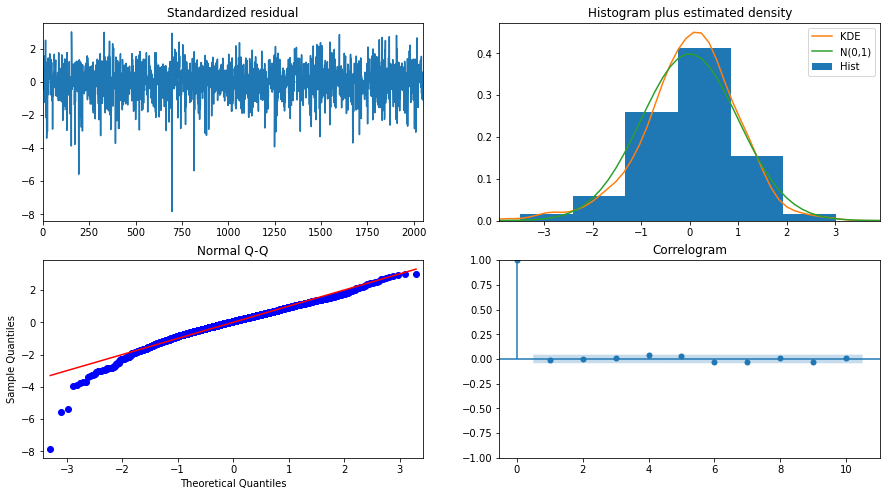

In [22]:
model.plot_diagnostics(figsize=(15,8));

In [23]:
predictions = model.predict(n_periods = len(dtest), exogenous=test_exg)

In [24]:
results = pd.DataFrame(data={'date': dtest.index, 'Predictions': predictions, 'Actuals': dtest.max_temp.values})
results.set_index('date', inplace=True)

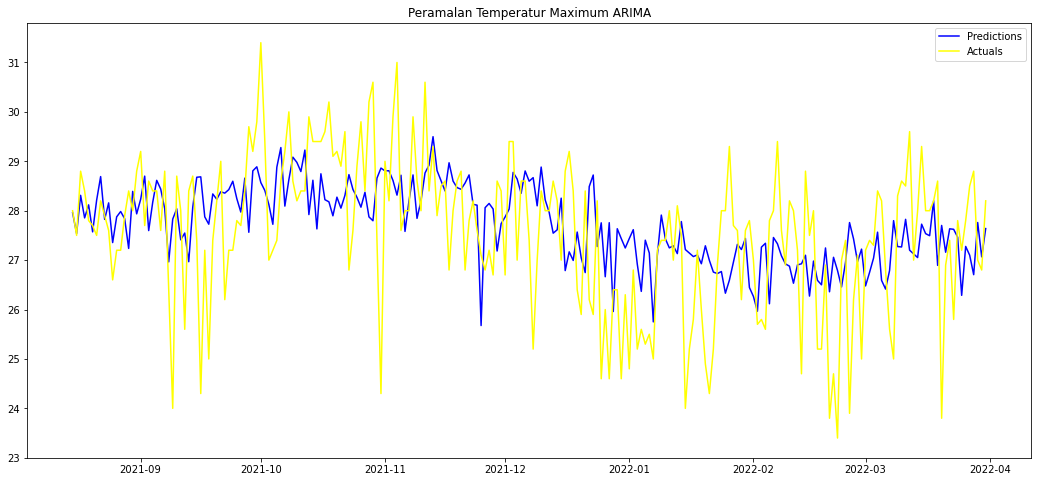

In [25]:
plt.figure(figsize=(18,8))
plt.title('Peramalan Temperatur Maximum ARIMA')
plt.plot(results.Predictions, label='Predictions', color='blue')
plt.plot(results.Actuals, label='Actuals', color='yellow')
plt.legend()

# Calculating Errors

In [26]:
test_MAE = mean_absolute_error(results.Actuals, results.Predictions)
test_RMSE = sqrt(mean_squared_error(results.Actuals, results.Predictions))
print(f'Mean Absolute Error is\t\t: {test_MAE}')
print(f'Root Mean Squared Error is\t: {test_RMSE}')

Mean Absolute Error is		: 1.134679715077115
Root Mean Squared Error is	: 1.4453653521235046


# Exp

In [27]:
model

ARIMA(order=(1, 0, 4), scoring_args={}, suppress_warnings=True)

# Model Update

In [28]:
model_up = model
model_up.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2053
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -3003.284
Date:                Sun, 07 Aug 2022   AIC                           6748.568
Time:                        14:04:55   BIC                           8836.207
Sample:                             0   HQIC                          7514.091
                               - 2053                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6744      0.415      1.625      0.104      -0.139       1.488
S1-365        -0.2492      0.190     -1.314      0.189      -0.621       0.122
C1-365         0.0023      0.186      0.013      0.990      -0.361       0.366
S2-365        -0.6026      0.149     -4.032      0.000      -0.896      -0.310
C2-365        -0.3989      0.139     -2.873      0.004      -0.671      -0.127
S3-365         0.0025      0.113      0.022      0.983      -0.219       0.224
C3-365         0.2053      0.122      1.685      0.092      -0.033       0.444
S4-365         0.0064      0.102      0.062      0.950      -0.194       0.207
C4-365        -0.1194      0.104     -1.144      0.253      -0.324       0.085
S5-365        -0.0182      0.095     -0.191      0.849      -0.205       0.169
C5-365         0.0048      0.093      0.052      0.959      -0.178       0.187
S6-365        -0.0163      0.091     -0.180      0.857      -0.194       0.161
C6-365        -0.0142      0.087     -0.163      0.870      -0.185       0.156
S7-365         0.0369      0.083      0.447      0.655      -0.125       0.199
C7-365        -0.0662      0.088     -0.756      0.450      -0.238       0.106
S8-365         0.0409      0.084      0.488      0.626      -0.123       0.205
C8-365         0.0506      0.081      0.622      0.534      -0.109       0.210
S9-365        -0.0576      0.079     -0.734      0.463      -0.212       0.096
C9-365        -0.0508      0.083     -0.612      0.540      -0.213       0.112
S10-365       -0.0601      0.079     -0.763      0.445      -0.214       0.094
C10-365       -0.0474      0.080     -0.592      0.554      -0.204       0.109
S11-365        0.0587      0.081      0.723      0.470      -0.100       0.218
C11-365        0.0060      0.075      0.079      0.937      -0.142       0.153
S12-365        0.0842      0.078      1.082      0.279      -0.068       0.237
C12-365       -0.1211      0.077     -1.576      0.115      -0.272       0.029
S13-365       -0.0039      0.074     -0.053      0.958      -0.149       0.141
C13-365       -0.0178      0.079     -0.225      0.822      -0.173       0.138
S14-365       -0.0004      0.077     -0.005      0.996      -0.151       0.150
C14-365        0.0170      0.075      0.228      0.820      -0.129       0.163
S15-365        0.0699      0.075      0.934      0.350      -0.077       0.217
C15-365        0.0749      0.075      0.993      0.321      -0.073       0.223
S16-365        0.0139      0.073      0.189      0.850      -0.130       0.158
C16-365       -0.0275      0.076     -0.362      0.718      -0.176       0.121
S17-365       -0.0864      0.075     -1.145      0.252      -0.234       0.061
C17-365        0.0483      0.073      0.663      0.507      -0.094       0.191
S18-365       -0.0101      0.073     -0.139      0.890      -0.153       0.133
C18-365        0.1262      0.074      1.705      0.088      -0.019       0.271
S19-365       -0.1071      0.072     -1.479      0.139      -0.249       0.035
C1

In [29]:
model_loc = 'ARIMA_models/max_temp.pkl'

In [30]:
np.arange(0, len(dtest)-1, 7)

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224])

In [31]:
224 + 7

231

In [32]:
(len(dtest)-1) - 224

4

In [33]:
224 + 4

228

In [34]:
def period_forecast(model_loc, period, data, exog):
    with open(model_loc, 'rb') as pkl:
        model = pickle.load(pkl) 
    predictions = []
    prog_count = 0
    for index in np.arange(0, len(data)-1, period):
        if index+period > len(data)-1:
            period = len(dtest) - 1 - index
        results = model.predict(n_periods=period, exogenous=exog.iloc[index:index+period])
        for result in results:
            prog_count += 1
            predictions.append(result)
            print(f"result: {result}\t\tprocess: {prog_count}/{len(data)}")
        model.update(data.iloc[index:index+period], exogenous=exog.iloc[index:index+period])
            
    return np.array(predictions)

In [35]:
temp_res_forecast = period_forecast(model_loc, period=3, data=dtest, exog=test_exg)

result: 27.95853437310675		process: 1/229
result: 27.538267108732477		process: 2/229
result: 28.310922846985417		process: 3/229
result: 27.90917590034313		process: 4/229
result: 28.13636714769277		process: 5/229
result: 27.57691156884852		process: 6/229
result: 28.183601878127696		process: 7/229
result: 28.63603548524937		process: 8/229
result: 27.828733317602115		process: 9/229
result: 28.186582769939744		process: 10/229
result: 27.49229568340259		process: 11/229
result: 28.050186801597405		process: 12/229
result: 27.764501263510613		process: 13/229
result: 27.721607933395628		process: 14/229
result: 27.16791718669278		process: 15/229
result: 28.690734759130898		process: 16/229
result: 28.113902832164243		process: 17/229
result: 28.277953872615		process: 18/229
result: 28.942814129578018		process: 19/229
result: 27.759386055609774		process: 20/229
result: 28.22229587432709		process: 21/229
result: 28.718256539712677		process: 22/229
result: 28.55567342976713		process: 23/229
result: 2

result: 26.19456452302506		process: 190/229
result: 27.09760394244056		process: 191/229
result: 26.90453031164281		process: 192/229
result: 25.295925347773135		process: 193/229
result: 26.313834230132002		process: 194/229
result: 27.39894673288545		process: 195/229
result: 26.49325684936013		process: 196/229
result: 26.26649685481995		process: 197/229
result: 26.69570585048454		process: 198/229
result: 25.836929587092285		process: 199/229
result: 26.28504219438186		process: 200/229
result: 26.600256774152683		process: 201/229
result: 27.651592686515983		process: 202/229
result: 26.498039466196445		process: 203/229
result: 26.250283699113147		process: 204/229
result: 26.97262630110777		process: 205/229
result: 27.842374880481124		process: 206/229
result: 27.200549507206514		process: 207/229
result: 27.1398705115696		process: 208/229
result: 27.71878749679795		process: 209/229
result: 27.162182170756147		process: 210/229
result: 27.741251254322208		process: 211/229
result: 27.31779183058

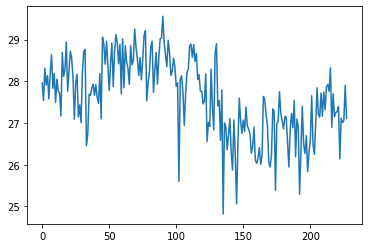

In [37]:
plt.plot(temp_res_forecast)